In [17]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import pickle

from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl
nCPU= 20
N=4


2025-12-10


In [5]:
# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
datasetdir = f'{workdir}/dataset_nc2017kremer'
phase=''
os.chdir(datasetdir)
# level 1
output_path = f'{workdir}/result/dataset_nc2017kremer'

samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'
print(samples_path)
use = 't00_FB_s119_g11048' # all genes have minreads 1, subset random set from here
# use = 't00_FB_s119_g14409'
tissues = pd.read_csv(f'tissues_{use}.tsv', sep='\t', index_col=0)

tissues.head()

/mnt/disk7t/xwj/axolotl_rev//result/dataset_nc2017kremer/samples


,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,FB,Fibroblast,119,11048,/mnt/disk7t/xwj/axolotl_rev/dataset_nc2017krem...,/mnt/disk7t/xwj/axolotl_rev/dataset_nc2017krem...


In [23]:

# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}

abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'padjust']
baselines = [ f'{m}_{score}' for m in ['ABEILLE','OUTRIDER', ] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ] + ['OUTSINGLE']

mymethods = [ f'{f}{m}' for f in ['f0.1', ] 
             for m in ['L20',] ]
methods = mymethods + baselines

num = 49
print(num, phase, methods)

49  ['f0.1L20', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTRIDER_padjust', 'OUTSINGLE']


In [7]:
## topn recall

def pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    """
    # 按predict和score排序
    ascend = score_order[ score_col ]
    sorted_data = res_data.pivot_table(columns=sample_col, index=gene_col, values=score_col).rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier

def sort_score_outlier_rank(res_data, df_outlier, ascend=True):
    sorted_data = res_data.rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier


In [8]:
# methods = [
# 'f0.1L20',
#  'ABEILLE_anomaly_score',
#  'ABEILLE_delta_count',
#  'ABEILLE_divergence_score',
#  'OUTRIDER_padjust',
#  'OUTSINGLE',
# ]

In [10]:
# 子集抽样
n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates) # 使用0-9作为随机种子
sample_sizes = [ 10, 30, 60, 100, ]

In [15]:
# outlier['Sample'].size == len(set(outlier['Sample']))

In [20]:
tissue_data = tissues.iloc[0]
t = tissue_data[0]  # TISSUE_ID
tn = tissue_data[1]  # TISSUE_NAME
ns = tissue_data[2]  # N_SAMPLE
ng = tissue_data[3]  # N_GENE
ctsfile = tissue_data[4]  # CTS_FILE
outlierfile = tissue_data[5]  # OUTLIER_FILE

cts = pd.read_csv(ctsfile, sep='\t', index_col=0)

base_prefix = f't01_{t}_s{ns}_g{ng}_nmd' # Version2.  six valid + equal number of NMD, must in sub samples
output_file = os.path.join(task_config_path, f'{base_prefix}_sampled_configs_dict.pkl')
sampled_configs = pickle.load(open(output_file, 'rb'))
    

    
# positive samples
outlier = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t', index_col=0)
# assert outlier['Sample'].size == len(set(outlier['Sample']))
outliers_used = outlier.copy()

for size in sample_sizes:
    
    dict_res = dict() # size
    dict_curve = dict()
    
    for seed in range(n_replicates):
        k = seed
        dict_res[k] = dict() # 10 seeds 
        dict_curve[k] = dict()
        # 获取当前抽样的配置
        current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
        task_config = current_config['config']
        samples_used = current_config['selected_samples']
        df_outlier = outliers_used.query('(Sample in @samples_used)').copy()
        
        for m in methods:
            # ==> level 3. (tissue, task, method)
            print(size, seed, m)
            dict_curve[k][m] = dict()
            for j,row in task_config.iterrows():
                if m.startswith('ABEILLE'):
                    method, score_col = m.split('_',1)
                    res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                    class_col = 'predict'
                    gene_col = 'Transcript'
                    sample_col = 'Sample'
                    dict_curve[k][m][j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                            
                elif m.startswith('OUTRIDER'):
                    method, score_col = m.split('_',1)
                    res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                    class_col = 'aberrant'
                    gene_col = 'geneID'
                    sample_col = 'sampleID'
                    dict_curve[k][m][j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                
                elif m == 'OUTSINGLE':
                    df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                    dict_curve[k][m][j] = sort_score_outlier_rank(df_pred, df_outlier)  
                                                
                else: # my method
                    df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                    dict_curve[k][m][j] = sort_score_outlier_rank(df_pred, df_outlier)
                                                    
    file = f'{metric_output_path}/{name_prefix}_size_{size}_rank{phase}.pkl'
    outputdata = [ t, tn, i, dict_curve ]
    import pickle
    with open(file, 'wb') as f: 
        pickle.dump( outputdata,  f )

10 0 f0.1L20
10 0 OUTRIDER_padjust
10 0 ABEILLE_anomaly_score
10 0 ABEILLE_delta_count
10 0 ABEILLE_divergence_score
10 0 OUTSINGLE
10 1 f0.1L20
10 1 OUTRIDER_padjust
10 1 ABEILLE_anomaly_score
10 1 ABEILLE_delta_count
10 1 ABEILLE_divergence_score
10 1 OUTSINGLE
10 2 f0.1L20
10 2 OUTRIDER_padjust
10 2 ABEILLE_anomaly_score
10 2 ABEILLE_delta_count
10 2 ABEILLE_divergence_score
10 2 OUTSINGLE
10 3 f0.1L20
10 3 OUTRIDER_padjust
10 3 ABEILLE_anomaly_score
10 3 ABEILLE_delta_count
10 3 ABEILLE_divergence_score
10 3 OUTSINGLE
10 4 f0.1L20
10 4 OUTRIDER_padjust
10 4 ABEILLE_anomaly_score
10 4 ABEILLE_delta_count
10 4 ABEILLE_divergence_score
10 4 OUTSINGLE
10 5 f0.1L20
10 5 OUTRIDER_padjust
10 5 ABEILLE_anomaly_score
10 5 ABEILLE_delta_count
10 5 ABEILLE_divergence_score
10 5 OUTSINGLE
10 6 f0.1L20
10 6 OUTRIDER_padjust
10 6 ABEILLE_anomaly_score
10 6 ABEILLE_delta_count
10 6 ABEILLE_divergence_score
10 6 OUTSINGLE
10 7 f0.1L20
10 7 OUTRIDER_padjust
10 7 ABEILLE_anomaly_score
10 7 ABEILLE_d

In [12]:
# dict_curve[0]['OUTSINGLE'][0] == dict_curve[0]['ABEILLE_delta_count'][0] 
sample_sizes

[10, 30, 60, 100]

t00_FB_s119_g11048


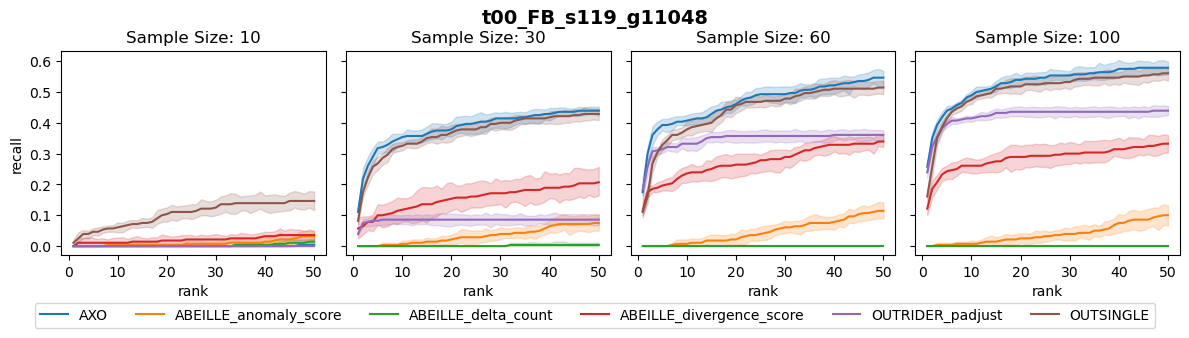

In [24]:
draw_methods = methods
plt.style.use('default')
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    print(name_prefix)

    fig, axes = plt.subplots(1, len(sample_sizes), figsize=(3*len(sample_sizes), 3), sharey=True )
    myindex = pd.MultiIndex.from_tuples([ (size, k) for size in sample_sizes for k in range(n_replicates) ],names=['size', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)

    for i, size in enumerate(sample_sizes):
        
        # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl'
        file = f'{metric_output_path}/{name_prefix}_size_{size}_rank{phase}.pkl'
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3]
            
        required_sets = 1
        max_bin = 50
        bins = list(range(0, max_bin + 1)) + [20000]
        nice_names = list(range(1,max_bin + 1))+[20000]#[ f'{x}%' for x in bins[:-1]]

        draw = \
        pd.concat([
        pd.concat( [ 
            pd.concat( [ (dict_curve[k][m][j]['rank']).value_counts(bins = bins, sort=False) for j in range(required_sets)],
                    axis=0, keys= range(required_sets))
            for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
        for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep']).rename(index={'f0.1L20':'AXO'}).reset_index()
        draw['rank'] = nice_names * len(draw_methods) * n_replicates
        draw = draw.query('rank < 10000').copy()
        draw['recall'] = draw.groupby(['method','rep'])['count'].cumsum()/len(df_outlier)

        sns.lineplot(
            data=draw,
            x="rank",
            y="recall",
            hue="method",
            palette='tab10',
            ax=axes[i],
            errorbar=('ci', 95),  # 90%置信区间
            n_boot=100,  # bootstrap采样次数
            alpha=1,
        )
        axes[i].set_title(f'Sample Size: {size}')
        #     # 1. 去掉子图自己的图例
        axes[i].get_legend().remove()

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5, 0),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)

    plt.tight_layout()
    # 给图例留一点底部空间
    fig.subplots_adjust(bottom=0.2)
    fig.suptitle(name_prefix, y=1.02, fontsize=14, fontweight='bold')
    plt.savefig(f'{workdir}/result/figure/kremer_topn_recall_sizes10-100_{name_prefix}.pdf',dpi=200, bbox_inches='tight')


In [26]:
## PCT
list_outlier_pct = [ 0.08, 0.16, 0.24,]
sample_sizes = [100, 50,]

In [28]:
# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE
    ctsfile = tissue_data['CTS_FILE']  # CTS_FILE
    outlierfile = tissue_data['OUTLIER_FILE']  # OUTLIER_FILE
    
    # positive samples
    outlier = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t', index_col=0)
    # assert outlier['Sample'].size == len(set(outlier['Sample']))
    outliers_used = outlier.copy()
    
    for pct in list_outlier_pct: # 增加pct的变化
        # 创建基础前缀
        name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}_pct{pct:.2f}'
        print(name_prefix)
        output_file = f'{task_config_path}/{name_prefix}_sampled_configs_dict.pkl'
        sampled_configs = pickle.load(open(output_file, 'rb'))

        for size in sample_sizes:
            
            dict_res = dict() # size
            dict_curve = dict()
            
            for seed in range(n_replicates):
                k = seed
                dict_res[k] = dict() # 10 seeds 
                dict_curve[k] = dict()
                # 获取当前抽样的配置
                current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
                task_config = current_config['config']
                samples_used = current_config['selected_samples']
                df_outlier = outliers_used.query('(Sample in @samples_used)').copy()
                
                for m in methods:
                    # ==> level 3. (tissue, task, method)
                    print(size, seed, m, pct)
                    dict_curve[k][m] = dict()
                
                    for j,row in task_config.iterrows():                    
                        if m.startswith('ABEILLE'):
                            method, score_col = m.split('_',1)
                            res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                            res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                            class_col = 'predict'
                            gene_col = 'Transcript'
                            sample_col = 'Sample'
                            dict_curve[k][m][j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                                    
                        elif m.startswith('OUTRIDER'):
                            method, score_col = m.split('_',1)
                            res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                            res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                            class_col = 'aberrant'
                            gene_col = 'geneID'
                            sample_col = 'sampleID'
                            dict_curve[k][m][j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                        
                        elif m == 'OUTSINGLE':
                            df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                            dict_curve[k][m][j] = sort_score_outlier_rank(df_pred, df_outlier)  
                                                    
                        else: # my method
                            df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                            dict_curve[k][m][j] = sort_score_outlier_rank(df_pred, df_outlier)
                                                        
            file = f'{metric_output_path}/{name_prefix}_size_{size}_rank{phase}.pkl'
            outputdata = [ t, tn, i, dict_curve ]        
                                    
            import pickle
            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )

t00_FB_s119_g11048_pct0.08
100 0 f0.1L20 0.08
100 0 ABEILLE_anomaly_score 0.08
100 0 ABEILLE_delta_count 0.08
100 0 ABEILLE_divergence_score 0.08
100 0 OUTRIDER_padjust 0.08
100 0 OUTSINGLE 0.08
100 1 f0.1L20 0.08
100 1 ABEILLE_anomaly_score 0.08
100 1 ABEILLE_delta_count 0.08
100 1 ABEILLE_divergence_score 0.08
100 1 OUTRIDER_padjust 0.08
100 1 OUTSINGLE 0.08
100 2 f0.1L20 0.08
100 2 ABEILLE_anomaly_score 0.08
100 2 ABEILLE_delta_count 0.08
100 2 ABEILLE_divergence_score 0.08
100 2 OUTRIDER_padjust 0.08
100 2 OUTSINGLE 0.08
100 3 f0.1L20 0.08
100 3 ABEILLE_anomaly_score 0.08
100 3 ABEILLE_delta_count 0.08
100 3 ABEILLE_divergence_score 0.08
100 3 OUTRIDER_padjust 0.08
100 3 OUTSINGLE 0.08
100 4 f0.1L20 0.08
100 4 ABEILLE_anomaly_score 0.08
100 4 ABEILLE_delta_count 0.08
100 4 ABEILLE_divergence_score 0.08
100 4 OUTRIDER_padjust 0.08
100 4 OUTSINGLE 0.08
100 5 f0.1L20 0.08
100 5 ABEILLE_anomaly_score 0.08
100 5 ABEILLE_delta_count 0.08
100 5 ABEILLE_divergence_score 0.08
100 5 OUTRIDER

t00_FB_s119_g11048_pct0.08
t00_FB_s119_g11048_pct0.16
t00_FB_s119_g11048_pct0.24


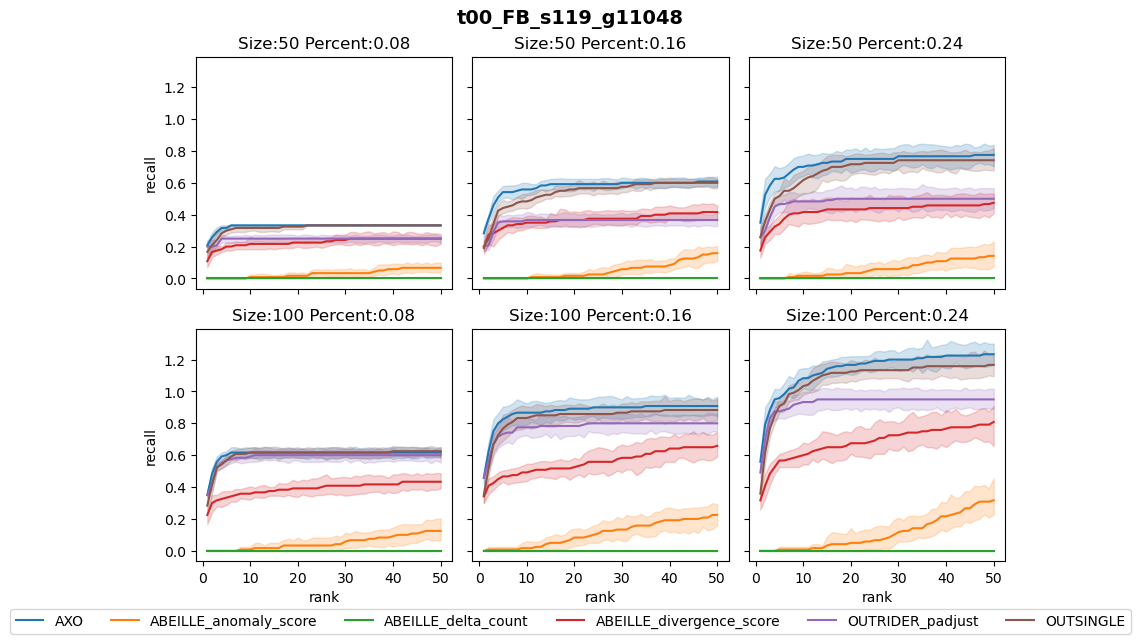

In [29]:
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    # fig, axes = plt.subplots(1, len(list_outlier_pct), figsize=(3*len(list_outlier_pct), 3), sharey=True )
    # myindex = pd.MultiIndex.from_tuples([ (pct, k) for pct in list_outlier_pct for k in range(n_replicates) ],names=['pct', 'seed'])
    fig, axes = plt.subplots(len(sample_sizes), len(list_outlier_pct), figsize=(3*len(list_outlier_pct), 3*len(sample_sizes)), sharey=True, sharex=True)
    myindex = pd.MultiIndex.from_tuples([ (size, pct, k) for size in sample_sizes for pct in list_outlier_pct for k in range(n_replicates) ],
                                        names=['size', 'pct', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)
    
    # 创建基础前缀
    for ax_i, pct in enumerate(list_outlier_pct): # 增加pct的变化
        # 创建基础前缀
        name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}_pct{pct:.2f}'
        print(name_prefix)

        for ax_j, size in enumerate(np.sort(sample_sizes)):
            if (size == 100 ) and (pct > 0.24):
                continue
                
            file = f'{metric_output_path}/{name_prefix}_size_{size}_rank{phase}.pkl'
            with open(file,'rb') as f:
                data_load = pickle.load(f)
            _t, _tn, _i, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3]
                
            required_sets = 1
            max_bin = 50
            bins = list(range(0, max_bin + 1)) + [20000]
            nice_names = list(range(1,max_bin + 1))+[20000]#[ f'{x}%' for x in bins[:-1]]

            draw = \
            pd.concat([
            pd.concat( [ 
                pd.concat( [ (dict_curve[k][m][j]['rank']).value_counts(bins = bins, sort=False) for j in range(required_sets)],
                        axis=0, keys= range(required_sets))
                for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
            for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep']).rename(index={ 'f0.1L20':'AXO'}).reset_index()
            draw['rank'] = nice_names * len(draw_methods) * n_replicates
            draw = draw.query('rank < 10000').copy()
            draw['recall'] = draw.groupby(['method','rep'])['count'].cumsum()/len(df_outlier)                
            
            sns.lineplot(
                data=draw,
                x="rank",
                y="recall",
                hue="method",
                palette='tab10',
                ax=axes[ax_j, ax_i],
                errorbar=('ci', 95),  # 90%置信区间
                n_boot=100,  # bootstrap采样次数
                alpha=1,
            )
            axes[ax_j,ax_i].set_title(f'Size:{size} Percent:{pct}')
                # 1. 去掉子图自己的图例
            axes[ax_j, ax_i].get_legend().remove()

    # 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
    handles, labels = axes[0, -1].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5,0),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)
    for ax_j in range(len(sample_sizes)):
        for ax_i in range(len(list_outlier_pct)):
            # 如果轴上没有任何 Line2D，就认定它为空
            if not axes[ax_j, ax_i].has_data():
                axes[ax_j, ax_i].set_visible(False)
    plt.tight_layout()
    # 给图例留一点底部空间
    fig.subplots_adjust(bottom=0.1)
    tissuse_title = f't{i:02d}_{t}_s{ns}_g{ng}'
    fig.suptitle(tissuse_title, y=1.02, fontsize=14, fontweight='bold')
    plt.savefig(f'{workdir}/result/figure/kremer_topn_recall_sizes50-100_pct_{name_prefix}.pdf',dpi=200, bbox_inches='tight')
